# Expression performance

In [1]:
import math
import iarray as ia
import numpy as np
from time import time
import ctypes
import matplotlib.pyplot as plt
import numexpr as ne
from iarray import udf
from iarray.py2llvm import float64
import numba

start_nthreads = 1
max_nthreads = 16
step_nthreads = 4
nrep = 4

In [2]:
str_expr = "(sin(x) - 1.35) * (cos(y) - 4.45) * (z - 8.5) * (2. * u - 0.5 * w)"
str_expr_np = "import numpy as np; (np.sin(x) - 1.35) * (np.cos(y) - 4.45) * (z - 8.5) * (2. * u - 0.5 * w)"


@numba.jit(parallel=True)
def poly_numba(x, y, z, u, w):
    o = np.empty(x.shape, x.dtype)
    for i in numba.prange(len(x)):
        o[i] = (np.sin(x[i]) - 1.35) * (np.cos(y[i]) - 4.45) * (z[i] - 8.5) * (2. * u[i] - 0.5 * w[i])
    return o


@udf.jit
def poly_udf(o: udf.Array(float64, 1), x: udf.Array(float64, 1), y: udf.Array(float64, 1),
             z: udf.Array(float64, 1), u: udf.Array(float64, 1), w: udf.Array(float64, 1)):
    n = x.shape[0]
    for i in range(n):
        o[i] = (math.sin(x[i]) - 1.35) * (math.cos(y[i]) - 4.45) * (z[i] - 8.5) * (2. * u[i] - 0.5 * w[i])
    return 0


In [3]:
# Define array params
shape = [60 * 1000 * 1000]
chunkshape = [30 * 1000 * 1000]
chunkshape2 = [8 * 1000]
blockshape = chunkshape2
dtshape = ia.dtshape(shape)
size = int(np.prod(shape))

bstorage = ia.StorageProperties("blosc", chunkshape, blockshape)
pstorage = ia.StorageProperties("plainbuffer", None, None)

eval_method = ia.EvalFlags(method="auto", engine="auto")

print("Setting up inputs...")
a1 = np.linspace(0, 10, size).reshape(shape)
a2 = np.linspace(0, 10, size).reshape(shape)
a3 = np.linspace(0, 10, size).reshape(shape)
a4 = np.linspace(0, 10, size).reshape(shape)
a5 = np.linspace(0, 10, size).reshape(shape)
ia1 = ia.linspace(dtshape, 0, 10, storage=bstorage, clevel=0)
ia2 = ia.linspace(dtshape, 0, 10, storage=bstorage, clevel=0)
ia3 = ia.linspace(dtshape, 0, 10, storage=bstorage, clevel=0)
ia4 = ia.linspace(dtshape, 0, 10, storage=bstorage, clevel=0)
ia5 = ia.linspace(dtshape, 0, 10, storage=bstorage, clevel=0)
iac1 = ia1.copy(storage=bstorage, clevel=9)
iac2 = ia1.copy(storage=bstorage, clevel=9)
iac3 = ia1.copy(storage=bstorage, clevel=9)
iac4 = ia1.copy(storage=bstorage, clevel=9)
iac5 = ia1.copy(storage=bstorage, clevel=9)

res = []
np_time = 0
if start_nthreads == 1:
    start_nthreads = 0
for nthreads in range(start_nthreads, max_nthreads + 1, step_nthreads):
    if nthreads == 0:
        nthreads = 1
    print(f"Num. threads: {nthreads}")
    res_i = []
    kwargs = dict(nthreads=nthreads, clib=ia.LZ4)

    # Numpy  (not multithreaded, so execute it the first time only)
    if np_time == 0:
        t = []
        for _ in range(nrep):
            t0 = time()
            b1 = exec(str_expr_np, {"x": a1, "y": a2, "z": a3, "u": a4, "w": a5})
            t1 = time()
            t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
        t.remove(max(t))
        np_time = np.mean(t)
    res_i.append(np_time)

    # numba
    t = []
    numba.set_num_threads(nthreads)
    for _ in range(nrep):
        t0 = time()
        b1 = poly_numba(a1, a2, a3, a4, a5)
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Numexpr
    t = []
    ne.set_num_threads(nthreads)
    for _ in range(nrep):
        t0 = time()
        b1 = ne.evaluate(str_expr, local_dict={'x': a1, 'y': a2, 'z': a3, "u": a4, "w": a5})
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Superchunk without compression
    expr = ia.Expr(eval_method=eval_method, clevel=0, **kwargs)
    expr.bind("x", ia1)
    expr.bind("y", ia2)
    expr.bind("z", ia3)
    expr.bind("u", ia4)
    expr.bind("w", ia5)
    expr.bind_out_properties(dtshape, storage=bstorage)
    expr.compile(str_expr)
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval()
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Superchunk with compression
    expr = ia.Expr(eval_method=eval_method, clevel=9, **kwargs)
    expr.bind("x", iac1)
    expr.bind("y", iac2)
    expr.bind("z", iac3)
    expr.bind("u", iac4)
    expr.bind("w", iac5)
    expr.bind_out_properties(dtshape, storage=bstorage)
    expr.compile(str_expr)
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval()
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Superchunk without compression and UDF
    expr = poly_udf.create_expr([ia1, ia2, ia3, ia4, ia5], dtshape, storage=bstorage, clevel=0, **kwargs)
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval()
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))

    # Superchunk with compression and UDF
    expr = poly_udf.create_expr([iac1, iac2, iac3, iac4, iac5], dtshape, storage=bstorage, clevel=9, **kwargs)
    t = []
    for _ in range(nrep):
        t0 = time()
        b1 = expr.eval()
        t1 = time()
        t.append(round(size / 2 ** 20 * 8 / (t1 - t0), 2))
    t.remove(max(t))
    res_i.append(np.mean(t))
    
    res.append(res_i)


Num. threads: 1
Num. threads: 4
Num. threads: 8
Num. threads: 12
Num. threads: 16


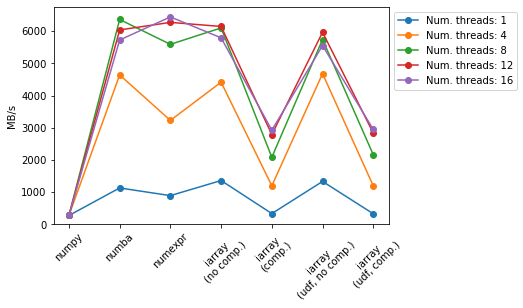

In [4]:
xticks = ("numpy", "numba", "numexpr", "iarray\n(no comp.)", "iarray\n(comp.)", "iarray\n(udf, no comp.)", "iarray\n(udf, comp.)")
plt.xticks(range(len(xticks)), xticks)
for i in range(len(res)):
    nthreads = 1 if i == 0 and start_nthreads == 0 else i * step_nthreads + start_nthreads 
    plt.plot(xticks, res[i - start_nthreads], "o-", label=f"Num. threads: {nthreads}")
plt.xticks(rotation=45)
plt.ylabel("MB/s")
plt.ylim(0)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()